In [6]:
import os
import random
import math
from pathlib import Path

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())

# for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


TensorFlow version: 2.16.2
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# If notebook is inside 'notebooks/' folder:
PROJECT_DIR = Path("/Users/mohanshankar/Auto_traffic_project")

DATA_DIR = PROJECT_DIR / "Data"
TRAIN_DIR = DATA_DIR / "Train"

print("Project Directory:", PROJECT_DIR)
print("Train Directory Exists:", TRAIN_DIR.exists())

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 43
EPOCHS = 20


Project Directory: /Users/mohanshankar/Auto_traffic_project
Train Directory Exists: True


In [8]:
from src.Data_utilis import load_dataset_paths

all_items = load_dataset_paths(str(TRAIN_DIR))
print("Total Training Images:", len(all_items))

from collections import Counter
cnt = Counter([label for _, label in all_items])
print("Classes found:", len(cnt))


Total Training Images: 39209
Classes found: 43


In [9]:
paths = [p for p, _ in all_items]
labels = [l for _, l in all_items]

train_paths, val_paths, train_labels, val_labels = train_test_split(
    paths,
    labels,
    test_size=0.15,
    random_state=SEED,
    stratify=labels
)

train_list = list(zip(train_paths, train_labels))
val_list = list(zip(val_paths, val_labels))

print("Training samples:", len(train_list))
print("Validation samples:", len(val_list))


Training samples: 33327
Validation samples: 5882


In [10]:
from src.Data_utilis import create_dataset

train_ds = create_dataset(train_list, batch_size=BATCH_SIZE, augment=True)
val_ds = create_dataset(val_list, batch_size=BATCH_SIZE, augment=False)

# Check a batch
for images, labels in train_ds.take(1):
    print("Batch images shape:", images.shape)
    print("Batch labels shape:", labels.shape)
    break


2025-11-25 12:15:28.040831: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-11-25 12:15:28.041063: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-25 12:15:28.041069: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-25 12:15:28.041319: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-25 12:15:28.041335: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Batch images shape: (16, 224, 224, 3)
Batch labels shape: (16, 43)


In [11]:
from src.model import build_model

model = build_model(
    num_classes=NUM_CLASSES,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)



🚀 EfficientNetB0 Model Created Successfully!



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 43)             │        55,083 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,104,654 (15.66 MB)

 Trainable params: 55,083 (215.17 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

MODEL_DIR = PROJECT_DIR / "models"
MODEL_DIR.mkdir(exist_ok=True)

MODEL_PATH = MODEL_DIR / "efficientnet_traffic_sign.h5"

callbacks = [
    ModelCheckpoint(str(MODEL_PATH), monitor="val_accuracy", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20


2025-11-25 12:15:37.631791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [13]:
model.save("Auto_traffic_sign_model.h5")
print("Model saved successfully!")

Model saved successfully!


In [15]:
try:
    history
except NameError:
    history = model.history


In [18]:
print(history.history.keys())


dict_keys([])


In [19]:
from tensorflow.keras.callbacks import CSVLogger

csv_logger = CSVLogger('training_log.csv', append=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[csv_logger]
)


Epoch 1/5
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 337s 162ms/step - accuracy: 0.7292 - loss: 0.9439 - val_accuracy: 0.8868 - val_loss: 0.4331
Epoch 2/5
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 347s 167ms/step - accuracy: 0.8615 - loss: 0.4610 - val_accuracy: 0.9262 - val_loss: 0.2855
Epoch 3/5
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 350s 168ms/step - accuracy: 0.8845 - loss: 0.3678 - val_accuracy: 0.9344 - val_loss: 0.2323
Epoch 4/5
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 368s 177ms/step - accuracy: 0.8992 - loss: 0.3159 - val_accuracy: 0.9493 - val_loss: 0.1895
Epoch 5/5
2083/2083 ━━━━━━━━━━━━━━━━━━━━ 376s 181ms/step - accuracy: 0.9045 - loss: 0.2944 - val_accuracy: 0.9549 - val_loss: 0.1678


In [20]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


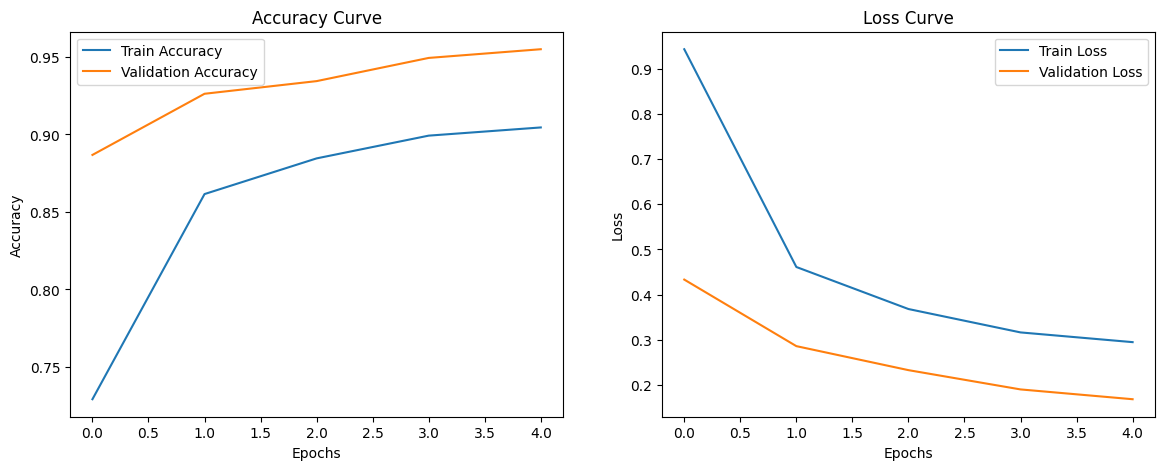

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [1]:
import json
import os

train_dir = "Data/Train"   # or your TRAIN_DIR variable if it exists

class_names = sorted(os.listdir(train_dir))
class_dict = {str(i): name for i, name in enumerate(class_names)}

with open("class_names.json", "w") as f:
    json.dump(class_dict, f)

print("class_names.json created!")
class_dict

class_names.json created!


{'0': '0',
 '1': '1',
 '2': '10',
 '3': '11',
 '4': '12',
 '5': '13',
 '6': '14',
 '7': '15',
 '8': '16',
 '9': '17',
 '10': '18',
 '11': '19',
 '12': '2',
 '13': '20',
 '14': '21',
 '15': '22',
 '16': '23',
 '17': '24',
 '18': '25',
 '19': '26',
 '20': '27',
 '21': '28',
 '22': '29',
 '23': '3',
 '24': '30',
 '25': '31',
 '26': '32',
 '27': '33',
 '28': '34',
 '29': '35',
 '30': '36',
 '31': '37',
 '32': '38',
 '33': '39',
 '34': '4',
 '35': '40',
 '36': '41',
 '37': '42',
 '38': '5',
 '39': '6',
 '40': '7',
 '41': '8',
 '42': '9'}